In [1]:
from create_overview import ResultAggregator
from copy import deepcopy
import re
from ast import literal_eval
from statistics import mean
import numpy as np
from collections import defaultdict
import pandas as pd

# 1. Starting

- There are two ways to start the code
 - You can either directly fetch the data from the project from [wandb](https://wandb.ai/site) or
 - you can read the data from a pre-existing csv file
- Note: Whenever you fetch the data directly from wandb, the data is automatically stored in a csv file called ```current_wandb_results_unprocessed.csv```. This measurement is taken, because downloading the data from wandb can take a while and sometimes even be interrupted due to connection issues (```Read timed out.``` etc.). Therefore, having a csv file can speed up the data reading.
- Initializing the object can happen in two ways, depending on whether you want to fetch the data from wandb or whether you want to read it from an existing csv file
- To fetch the data directly from wand to you need to pass a valid wand api key:

```
ra = ResultAggregator(wandb_api_key={WAND_API_KEY})

```
- To use the data from an existing csv file, you need to pass the path to the csv file (in the example below, the path to the automatically generated csv file is given):

```
ra = ResultAggregator(path_to_csv_export="current_wandb_results_unprocessed.csv")

```

- Optionally, you can set the argument ```verbose_logging```to ```False```. This might be usefule, to avoid overwhelming logging messages either in the terminal or in a notebook cell. The logs are saved in a log file in the log directory anyway.
- Passing the argument ```verbose_logging``` can be done like this:

```
ra = ResultAggregator(wandb_api_key={WAND_API_KEY}, verbose_logging=False)

```

```
ra = ResultAggregator(path_to_csv_export="current_wandb_results_unprocessed.csv", verbose_logging=False)

```

- It is important to note that all overviews and aggregates evolves around the score `macro-f1`. But you can overwrite this by passing `score` with the name of the score you are interested in, like this:

```
ra = ResultAggregator(path_to_csv_export="current_wandb_results_unprocessed.csv", score='micro-f1')

```
 

In [2]:
wandb_api_key = "3b7e4cee8259b9c6522aa3adef3833e6c109f000"
ra = ResultAggregator(wandb_api_key=wandb_api_key, verbose_logging=False)
#ra = ResultAggregator(path_to_csv_export="current_wandb_results_unprocessed.csv", verbose_logging=False)


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
Traceback (most recent call last):
  File "/Users/vetonmatoshi/Documents/Git/LEXTREME/utils/create_overview.py", line 159, in fetch_data
    entry["finetuning_task"] = x.config['finetuning_task']
KeyError: 'finetuning_task'
Traceback (most recent call last):
  File "/Users/vetonmatoshi/Documents/Git/LEXTREME/utils/create_overview.py", line 159, in fetch_data
    entry["finetuning_task"] = x.config['finetuning_task']
KeyError: 'finetuning_task'
Traceback (most recent call last):
  File "/Users/vetonmatoshi/Documents/Git/LEXTREME/utils/create_overview.py", line 159, in fetch_data
    entry["finetuning_task"] = x.config['finetuning_task']
KeyError: 'finetuning_task'
Traceback (most recent call last):
  File "/Users/vetonmatoshi/Documents/Git/LEXTREME/utils/create_overview.p

# 2. General information

- When fetching the data from wandb, the data is processed and saved to a dataframe called `results` which is an object variable
- **In contains only runs that are finished. Failed or crashed runs on wandb have been removed**
- You can access the processed data like this `ra.results`
- This data will be used to calculate the scores
- All overviews with the calculated aggregate scores will be saved to dataframes as well, which can be accessed likewise



# 2. Overviews

- The code was writing while some runs for certain had not been finished 
- Therefore, you can specify whether the generated overviews should consider only taks whose run had been completed entirely. This is automatically done by setting ```only_completed_tasks```to ```True``` as a default value.
- In case you want to see interim results, including tasks that have not been completed yet, you can set ```only_completed_tasks```to ```False``` when intitiliazing:

```
ra = ResultAggregator(path_to_csv_export="current_wandb_results_unprocessed.csv", only_completed_tasks=False)

```

- The code will create a bunch of different overviews that will be described in the following

## 2.1. Incomplete tasks

- If you want to generate an overview of incomplete tasks you run the following: `ra.check_seed_per_task()`
- This method will check if all task have the required number of finished runs with the seeds 1,2,3


In [3]:
seed_check = ra.check_seed_per_task()
seed_check.head(15)

,finetuning_task,_name_or_path,language,missing_seeds
0,swiss_judgment_prediction,dlicari/Italian-Legal-BERT,it,[2]


##  2.2. Overviews along scores

- The method ```create_overview_of_results_per_seed()``` will generate an overview of the required score per seed and give a mean value. If not specified otherwise, the score defined during initializing will be used, i.e. `macro-f1`

In [4]:
ra.create_overview_of_results_per_seed()



seed,dataset,finetuning_task,_name_or_path,language,1,2,3,mean_over_seeds
0,brazilian_court_decisions,brazilian_court_decisions_judgment,distilbert-base-multilingual-cased,pt,0.499619,0.474800,0.533155,0.502525
1,brazilian_court_decisions,brazilian_court_decisions_judgment,microsoft/Multilingual-MiniLM-L12-H384,pt,0.434852,0.576685,0.469231,0.493589
2,brazilian_court_decisions,brazilian_court_decisions_judgment,microsoft/mdeberta-v3-base,pt,0.655753,0.693536,0.624596,0.657961
3,brazilian_court_decisions,brazilian_court_decisions_judgment,neuralmind/bert-base-portuguese-cased,pt,0.595290,0.715128,0.624258,0.644892
4,brazilian_court_decisions,brazilian_court_decisions_judgment,xlm-roberta-base,pt,0.628656,0.638225,0.695681,0.654187
...,...,...,...,...,...,...,...,...
266,online_terms_of_service,online_terms_of_service_unfairness_levels,nlpaueb/legal-bert-base-uncased,en,0.899983,0.849456,0.917298,0.888912
267,online_terms_of_service,online_terms_of_service_unfairness_levels,roberta-base,en,0.786267,0.586117,0.644054,0.672146
268,online_terms_of_service,online_terms_of_service_unfairness_levels,xlm-roberta-base,all,0.830636,0.800057,0.794426,0.808373
269,online_terms_of_service,online_terms_of_service_unfairness_levels,xlm-roberta-large,all,0.785925,0.882454,0.839964,0.836114


- If you want to to generate an overview for another score, let's say `micro-f1`, you can pass the name of the score as a variable to the function


In [5]:
ra.create_overview_of_results_per_seed(score='micro-f1')

seed,dataset,finetuning_task,_name_or_path,language,1,2,3,mean_over_seeds
0,brazilian_court_decisions,brazilian_court_decisions_judgment,distilbert-base-multilingual-cased,pt,0.525926,0.479012,0.614815,0.539918
1,brazilian_court_decisions,brazilian_court_decisions_judgment,microsoft/Multilingual-MiniLM-L12-H384,pt,0.407407,0.612346,0.486420,0.502058
2,brazilian_court_decisions,brazilian_court_decisions_judgment,microsoft/mdeberta-v3-base,pt,0.703704,0.728395,0.669136,0.700412
3,brazilian_court_decisions,brazilian_court_decisions_judgment,neuralmind/bert-base-portuguese-cased,pt,0.607407,0.745679,0.664198,0.672428
4,brazilian_court_decisions,brazilian_court_decisions_judgment,xlm-roberta-base,pt,0.664198,0.674074,0.733333,0.690535
...,...,...,...,...,...,...,...,...
266,online_terms_of_service,online_terms_of_service_unfairness_levels,nlpaueb/legal-bert-base-uncased,en,0.932039,0.932039,0.951456,0.938511
267,online_terms_of_service,online_terms_of_service_unfairness_levels,roberta-base,en,0.883495,0.854369,0.854369,0.864078
268,online_terms_of_service,online_terms_of_service_unfairness_levels,xlm-roberta-base,all,0.882494,0.880096,0.858513,0.873701
269,online_terms_of_service,online_terms_of_service_unfairness_levels,xlm-roberta-large,all,0.908873,0.940048,0.906475,0.918465


## 2.3 Report
- As a shortcut, you can use the method `create_report()`
- It will run `create_overview_of_results_per_seed` over different scores and give an overview of missing runs.
- The overviews will be saved in an excel file called `report.xlsx` in the directory `results`

In [6]:
ra.create_report()

/Users/vetonmatoshi/opt/anaconda3/envs/bfh/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


- When running `create_report()` the generated overviews will be stored as dataframes in object variables that can be directly accessed.
- Currently, the variables are:
  - seed_check
  - macro_f1_overview
  - micro_f1_overview
  - weighted_f1_overview
  - accuracy_normalized_overview
  
- You can use them for visualization purposes

<AxesSubplot: xlabel='finetuning_task'>

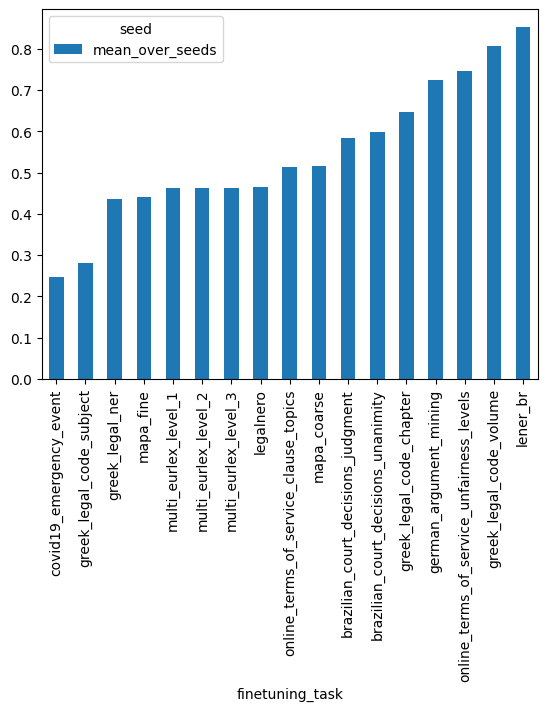

In [7]:
ra.macro_f1_overview[['finetuning_task', 'mean_over_seeds']].groupby('finetuning_task').mean().sort_values('mean_over_seeds').plot.bar()


<AxesSubplot: xlabel='finetuning_task'>

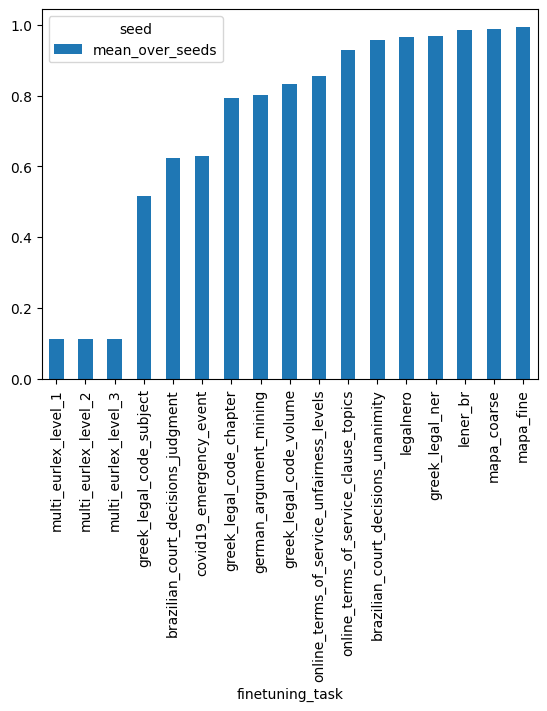

In [8]:
ra.accuracy_normalized_overview[['finetuning_task', 'mean_over_seeds']].groupby('finetuning_task').mean().sort_values('mean_over_seeds').plot.bar()

### 2.4. Aggregated scores

### 2.4.1. Language aggregate

`DEFINITION`: *"1. Average over configurations (e.g. judgment and unanimity) inside datasets, 2. Average over datasets, 3. Average over languages"*

- The aggregated score along languages (the language aggregate score) can be generated with the method `get_language_aggregated_score()`
  - Since, the default score is `macro-f1`, the aggregate score is based on macro-f1. You can change this by defining another score when initializing the object (see description above).
- The result dataframe is stored in the variable `language_aggregated_score`
- When calling the method, the resulting dataframe is saved to a csv and xlsx file, called `language_aggregated_scores` in the results folder

In [9]:
ra.get_language_aggregated_score()
ra.language_aggregated_score.head()

,aggregated_score,bg,cs,da,de,el,en,es,et,fi,...,lv,mt,nb,nl,pl,pt,ro,sk,sl,sv
Model,,,,,,,,,,,,,,,,,,,,,
distilbert-base-multilingual-cased,0.547834,0.659323,0.613012,0.568944,0.637161,0.532597,0.536819,0.665439,0.571229,0.557057,...,0.567291,0.569854,0.165728,0.418094,0.433095,0.646066,0.571184,0.583682,0.633116,0.598854
microsoft/Multilingual-MiniLM-L12-H384,0.518236,0.642836,0.585486,0.549076,0.603017,0.489676,0.433816,0.631382,0.5899,0.560881,...,0.59698,0.558671,0.0125,0.380152,0.340335,0.628214,0.573017,0.588705,0.62206,0.575097
microsoft/mdeberta-v3-base,0.584848,0.617826,0.602867,0.603803,0.66871,0.552682,0.583241,0.685902,0.617106,0.612949,...,0.622227,0.602878,0.211417,0.478641,0.50397,0.686489,0.607903,0.652467,0.65156,0.664537
xlm-roberta-base,0.571183,0.680046,0.624364,0.583528,0.654654,0.546567,0.582384,0.635651,0.58694,0.57083,...,0.602697,0.578208,0.209394,0.448884,0.506523,0.68288,0.588857,0.606957,0.662352,0.613011
xlm-roberta-large,0.601556,0.64602,0.628092,0.651271,0.676153,0.592809,0.626655,0.698442,0.626903,0.617343,...,0.664331,0.598207,0.277714,0.447437,0.554316,0.683864,0.592867,0.620074,0.681906,0.624615


## - You can restrict the list of tasks you want to consider by passing a list of task names 

In [10]:
ra.get_language_aggregated_score(task_constraint=['german_argument_mining'])
ra.language_aggregated_score.head(50)

,aggregated_score,bg,cs,da,de,el,en,es,et,fi,...,lv,mt,nb,nl,pl,pt,ro,sk,sl,sv
Model,,,,,,,,,,,,,,,,,,,,,
distilbert-base-multilingual-cased,0.698537,,,,0.698537,,,,,,...,,,,,,,,,,
microsoft/Multilingual-MiniLM-L12-H384,0.735768,,,,0.735768,,,,,,...,,,,,,,,,,
microsoft/mdeberta-v3-base,0.71802,,,,0.71802,,,,,,...,,,,,,,,,,
xlm-roberta-base,0.709682,,,,0.709682,,,,,,...,,,,,,,,,,
xlm-roberta-large,0.733849,,,,0.733849,,,,,,...,,,,,,,,,,
iarfmoose/roberta-base-bulgarian,,,,,,,,,,,...,,,,,,,,,,
UWB-AIR/Czert-B-base-cased,,,,,,,,,,,...,,,,,,,,,,
Maltehb/danish-bert-botxo,,,,,,,,,,,...,,,,,,,,,,
dbmdz/bert-base-german-cased,0.726351,,,,0.726351,,,,,,...,,,,,,,,,,


### 2.4.2. Config aggregate

- The aggregated score along configs (the task config score) can be generated with the method `get_config_aggregated_score()`
  - Since, the default score is `macro-f1`, the aggregate score is based on macro-f1. You can change this by defining another score when initializing the object (see description above).
  - Per default the method calcualtes the average over config, dataset, language. To overwrite this behavious, i.e. to calculate the avergae score not over languages, you can set average_over_language=False. The resulting values should be similar to the aggregate scores we find on wandb
- The result dataframe is stored in the variable `config_aggregated_score`
- When calling the method, the resulting dataframe is saved to a csv and xlsx file
  - Depending on whether you average over language or not the name of the file is called `config_aggregated_scores_simple` (not averaged over language) OR `config_aggregated_scores_average_over_language` (averaged over language) in the results folder
  
**The dataset aggregate score is built on top of the results of the config aggregate score**

In [11]:
ra.get_config_aggregated_score()
ra.config_aggregated_score.head()

,aggregated_score,brazilian_court_decisions_judgment,brazilian_court_decisions_unanimity,covid19_emergency_event,german_argument_mining,greek_legal_code_chapter,greek_legal_code_subject,greek_legal_code_volume,greek_legal_ner,legalnero,lener_br,mapa_coarse,mapa_fine,multi_eurlex_level_1,multi_eurlex_level_2,multi_eurlex_level_3,online_terms_of_service_clause_topics,online_terms_of_service_unfairness_levels,swiss_judgment_prediction
Model,,,,,,,,,,,,,,,,,,,
distilbert-base-multilingual-cased,0.575229,0.502525,0.588022,0.220667,0.698537,0.698964,0.347726,0.850485,0.389579,0.491132,0.796651,0.592824,0.501129,0.636105,0.636105,0.636105,0.446234,0.653622,0.667709
microsoft/Multilingual-MiniLM-L12-H384,0.519916,0.481232,0.546636,0.023728,0.735768,0.395646,0.054731,0.816617,0.419497,0.468329,0.857039,0.591456,0.502125,0.619931,0.619931,0.619931,0.179959,0.749064,0.676875
microsoft/mdeberta-v3-base,0.594034,0.668255,0.526872,0.254883,0.71802,0.586163,0.123597,0.855533,0.451794,0.463949,0.877922,0.651739,0.56439,0.650556,0.650556,0.650556,0.51119,0.795365,0.69127
xlm-roberta-base,0.602928,0.654187,0.615876,0.251612,0.709682,0.698776,0.153901,0.859264,0.468306,0.471324,0.864691,0.594283,0.519783,0.656097,0.656218,0.656218,0.534906,0.794169,0.693404
xlm-roberta-large,0.620811,0.550644,0.623047,0.291545,0.733849,0.747135,0.391375,0.58339,0.470351,0.477921,0.881422,0.645656,0.531329,0.680765,0.680765,0.680765,0.683361,0.83129,0.689995


### 2.4.3. Dataset aggregate
`DEFINITION`: *"1. Average over languages inside configurations, 2. Average over configurations (e.g. judgment and unanimity) inside datasets, 3. Average over Datasets"*

- The aggregated score along datasets (the dataset aggregate score) can be generated with the method `get_dataset_aggregated_score()`
  - Since, the default score is `macro-f1`, the aggregate score is based on macro-f1. You can change this by defining another score when initializing the object (see description above).
  - Per default the method calcualtes the average over config, dataset, language. To overwrite this behavious, i.e. to calculate the avergae score not over languages, you can set average_over_language=False. The resulting values should be similar to the aggregate scores we find on wandb
- The result dataframe is stored in the variable `dataset_aggregated_score`
- When calling the method, the resulting dataframe is saved to a csv and xlsx file
  - Depending on whether you average over language or not the name of the file is called `dataset_aggregated_scores_simple` (not averaged over language) OR `dataset_aggregated_scores_average_over_language` (averaged over language) in the results folder

In [27]:
ra.get_dataset_aggregated_score()
ra.dataset_aggregated_score.head()

,aggregated_score,BC,C19,GAM,GLC,GLN,LNR,LNB,M,MUL,OTS,SJP
Model,,,,,,,,,,,,
distilbert-base-multilingual-cased,0.561359,0.545273,0.220667,0.698537,0.632391,0.389579,0.491132,0.796651,0.546977,0.636105,0.549928,0.667709
microsoft/Multilingual-MiniLM-L12-H384,0.522612,0.513934,0.023728,0.735768,0.422332,0.419497,0.468329,0.857039,0.546791,0.619931,0.464511,0.676875
microsoft/mdeberta-v3-base,0.589915,0.597564,0.254883,0.71802,0.521764,0.451794,0.463949,0.877922,0.608064,0.650556,0.653277,0.69127
xlm-roberta-base,0.594768,0.635032,0.251612,0.709682,0.570647,0.468306,0.471324,0.864691,0.557033,0.656177,0.664538,0.693404
xlm-roberta-large,0.612043,0.586846,0.291545,0.733849,0.573967,0.470351,0.477921,0.881422,0.588492,0.680765,0.757326,0.689995


In [28]:
ra.get_dataset_aggregated_score(average_over_language=False)
ra.dataset_aggregated_score.head()

,aggregated_score,BC,C19,GAM,GLC,GLN,LNR,LNB,M,MUL,OTS,SJP
Model,,,,,,,,,,,,
distilbert-base-multilingual-cased,0.573957,0.545273,0.394384,0.698537,0.632391,0.389579,0.491132,0.796651,0.506236,0.636341,0.556045,0.666957
microsoft/Multilingual-MiniLM-L12-H384,0.521886,0.513934,0.051406,0.735768,0.422332,0.419497,0.468329,0.857039,0.507148,0.620181,0.468692,0.676421
microsoft/mdeberta-v3-base,0.601,0.597564,0.416076,0.71802,0.521764,0.451794,0.463949,0.877922,0.566469,0.650439,0.656861,0.690137
xlm-roberta-base,0.605815,0.635032,0.418726,0.709682,0.570647,0.468306,0.471324,0.864691,0.514795,0.656204,0.671955,0.682596
xlm-roberta-large,0.629749,0.586846,0.51872,0.733849,0.573967,0.470351,0.477921,0.881422,0.561942,0.680804,0.758879,0.682537


## 3. Additional features

### 3.1. Task constraint
- We want to calculate a task aggregate score
- It might be useful, to remove some tasks from the calculations
- This can be done by passing a list of tasks we want to consider; see the example below

In [29]:
print('Results for all available tasks:')
print('------------------------')
ra.get_language_aggregated_score()
ra.get_dataset_aggregated_score(average_over_language=True)

lm = ["distilbert-base-multilingual-cased", "microsoft/Multilingual-MiniLM-L12-H384", "xlm-roberta-base", "microsoft/mdeberta-v3-base", "xlm-roberta-large"]

for x in lm:
    print(x)
    print('\t','language aggregated: ',ra.language_aggregated_score.at[x,'aggregated_score'])
    print('\t','dataset aggregated: ', ra.dataset_aggregated_score.at[x,'aggregated_score'])
    print('-----------------------------------')

print('\n##########################\n')

tasks_we_are_interested_in = ['mapa_fine', 'german_argument_mining']
print('Results for only selected tasks:', ', '.join(tasks_we_are_interested_in))
print('------------------------')
ra.get_language_aggregated_score(task_constraint=tasks_we_are_interested_in)
ra.get_dataset_aggregated_score(average_over_language=True, task_constraint=tasks_we_are_interested_in)

lm = ["distilbert-base-multilingual-cased", "microsoft/Multilingual-MiniLM-L12-H384", "xlm-roberta-base", "microsoft/mdeberta-v3-base", "xlm-roberta-large"]

for x in lm:
    print(x)
    print('\t','language aggregated: ',ra.language_aggregated_score.at[x,'aggregated_score'])
    print('\t','dataset aggregated: ', ra.dataset_aggregated_score.at[x,'aggregated_score'])
    print('-----------------------------------')

print('\n##########################\n')

ra.reset_list_of_available_languages()


Results for all available tasks:
------------------------
distilbert-base-multilingual-cased
	 language aggregated:  0.5478341739128366
	 dataset aggregated:  0.5613591348620459
-----------------------------------
microsoft/Multilingual-MiniLM-L12-H384
	 language aggregated:  0.5182362303677861
	 dataset aggregated:  0.5226122227146502
-----------------------------------
xlm-roberta-base
	 language aggregated:  0.571182784470856
	 dataset aggregated:  0.5947678502005855
-----------------------------------
microsoft/mdeberta-v3-base
	 language aggregated:  0.5848484656521846
	 dataset aggregated:  0.589914856436789
-----------------------------------
xlm-roberta-large
	 language aggregated:  0.6015556130531355
	 dataset aggregated:  0.6120433301450202
-----------------------------------

##########################

Results for only selected tasks: mapa_fine, german_argument_mining
------------------------
distilbert-base-multilingual-cased
	 language aggregated:  0.5051139152909249
	 da

### 3.2. Language constraint
- We want to calculate a language aggregate score
- It might be useful, to remove some languages from the calculations
- This can be done with the method `remove_languages({LANGUAGE_ID})`
- You can reset the initial number of languages with the method `reset_list_of_available_languages()`
- This might be useful, if you want to gauge the influence of certain languages on the overall scores (see example below)

In [30]:
ra.reset_list_of_available_languages()

print('Results with all available languages:')
print('------------------------')
ra.get_language_aggregated_score()
ra.get_dataset_aggregated_score(average_over_language=True)

lm = ["distilbert-base-multilingual-cased", "microsoft/Multilingual-MiniLM-L12-H384", "xlm-roberta-base", "microsoft/mdeberta-v3-base", "xlm-roberta-large"]

for x in lm:
    print(x)
    print('\t','language aggregated: ',ra.language_aggregated_score.at[x,'aggregated_score'])
    print('\t','dataset aggregated: ', ra.dataset_aggregated_score.at[x,'aggregated_score'])
    print('-----------------------------------')

print('\n##########################\n')

ra.reset_list_of_available_languages()

ra.remove_languages('pt')

print('Results without Portuguese:')
print('------------------------')
ra.get_language_aggregated_score()
ra.get_dataset_aggregated_score(average_over_language=True)

lm = ["distilbert-base-multilingual-cased", "microsoft/Multilingual-MiniLM-L12-H384", "xlm-roberta-base", "microsoft/mdeberta-v3-base", "xlm-roberta-large"]

for x in lm:
    print(x)
    print('\t','language aggregated: ',ra.language_aggregated_score.at[x,'aggregated_score'])
    print('\t','dataset aggregated: ', ra.dataset_aggregated_score.at[x,'aggregated_score'])
    print('-----------------------------------')

print('\n##########################\n')

ra.reset_list_of_available_languages()


Results with all available languages:
------------------------
distilbert-base-multilingual-cased
	 language aggregated:  0.5478341739128366
	 dataset aggregated:  0.5613591348620459
-----------------------------------
microsoft/Multilingual-MiniLM-L12-H384
	 language aggregated:  0.5182362303677861
	 dataset aggregated:  0.5226122227146502
-----------------------------------
xlm-roberta-base
	 language aggregated:  0.571182784470856
	 dataset aggregated:  0.5947678502005855
-----------------------------------
microsoft/mdeberta-v3-base
	 language aggregated:  0.5848484656521846
	 dataset aggregated:  0.589914856436789
-----------------------------------
xlm-roberta-large
	 language aggregated:  0.6015556130531355
	 dataset aggregated:  0.6120433301450202
-----------------------------------

##########################

Results without Portuguese:
------------------------
distilbert-base-multilingual-cased
	 language aggregated:  0.5437411718533487
	 dataset aggregated:  0.5610983848289

## 4. Analysis

### 4.1. Prepare tables for LaTeX

- In order for this to work, you need to make the following imports in your LaTeX document

```
\usepackage{rotating}
\usepackage{adjustbox}
```

### 4.2. Define functions and variables that we will need

In [31]:
# List of mono- and multilingual models
multilingual_models = [lm for lm, lang in ra.meta_infos['model_language_lookup_table'].items() if lang == "all"]
monolingual_models = [lm for lm, lang in ra.meta_infos['model_language_lookup_table'].items() if lang != "all"]

In [32]:
# We round all scores (macro-F1 values)

def round_scores(score):
    if type(score)==float:
        return round(score*100,1)
    else:
        return score
    
    
def create_average_aggregates(target, score, language_types=None):
    
    multilingual_models = [lm for lm, lang in ra.meta_infos['model_language_lookup_table'].items() if lang == "all"]
    monolingual_models = [lm for lm, lang in ra.meta_infos['model_language_lookup_table'].items() if lang != "all"]
    
    '''
    Gegenartes scores based on normal average for predcit and eval values.
    Gets average over all seeds per task.
    Gets avergage over targets.
    The target is either the dataset or the language.
    
    Parameters
    ----------
    target : The value you want to create the aggregate score with. It canbe either 'language' or 'dataset'.
    score : Define which score you want to use. If you choose 'macro-f1', it will be converted to 'predict/_macro_f1'. If you want to use the values from the eval dataset, use the prefix 'eval_', i.e. 'eval/macro-f1'. 
    '''
    
    eval_macro_f1 = ra.create_overview_of_results_per_seed(score=score,only_completed_tasks=True)
    eval_macro_f1 = eval_macro_f1[["_name_or_path", target, "mean_over_seeds"]]
    eval_macro_f1 = eval_macro_f1.sort_values(target)
    df_aggregated = pd.pivot_table(eval_macro_f1,index="_name_or_path", columns=target, values="mean_over_seeds", aggfunc=np.mean)
    
    if language_types == 'multi':
        df_aggregated = df_aggregated.loc[multilingual_models]
    elif language_types == 'mono':
        df_aggregated = df_aggregated.loc[monolingual_models]
            
    df_aggregated.columns.name=""
    df_aggregated.index.rename("Model", inplace=True)
    df_aggregated.dropna(axis=1, how='all', inplace=True)
    df_aggregated.fillna('', inplace=True)
    
    if target=="language":
        df_aggregated = df_aggregated.rename(columns={'all':'multilingual'})
    
    first_column = 'Mean over '+re.sub('_',' ',target)+'s'
    columns = df_aggregated.columns.tolist() 
    df_aggregated[first_column] = df_aggregated.mean(axis=1)
    df_aggregated = df_aggregated[[first_column] + [col for col in columns if col not in first_column]]
    
    # Insert abbreviations
    if target == "finetuning_task":
        for finetuning_task, abbreviation in ra.meta_infos["task_abbreviations"].items():
            df_aggregated.rename(columns={finetuning_task: abbreviation}, inplace=True)
            
    df_aggregated = df_aggregated.applymap(round_scores)
    return df_aggregated
    

### 4.3.  Compare eval and prediction mean of macro-F1

### 4.3.1. Create Averages over finetuning tasks


In [33]:
# predict macro-f1
predict_macro_f1_average = create_average_aggregates(target='finetuning_task',score='macro-f1', language_types='multi')

# eval macro-f1
eval_macro_f1_average = create_average_aggregates(target='finetuning_task',score='eval/macro-f1', language_types='multi')

combined_macro_f1_average = deepcopy(eval_macro_f1_average)


for i, _ in combined_macro_f1_average.iterrows():
    for c in combined_macro_f1_average.columns.tolist():
        eval_score = eval_macro_f1_average.at[i, c]
        predict_score = predict_macro_f1_average.at[i, c]
        combined_macro_f1_average.at[i, c]=str(eval_score)+'/'+str(predict_score)
        
combined_macro_f1_average
    

,Mean over finetuning tasks,BCDJ,BCDU,C19EE,GAM,GLCC,GLCS,GLCV,GLN,LNR,LNB,MC,MF,MUL1,MUL2,MUL3,OTSCT,OTSUL
Model,,,,,,,,,,,,,,,,,,
distilbert-base-multilingual-cased,61.3/57.5,52.1/50.3,60.0/58.8,41.4/39.5,70.6/69.5,68.0/70.0,33.9/33.2,84.9/85.2,38.9/38.1,63.5/48.4,70.3/78.7,78.7/61.3,58.8/40.6,68.2/63.6,68.2/63.6,68.2/63.6,49.6/46.2,66.9/67.2
microsoft/Multilingual-MiniLM-L12-H384,54.5/50.8,52.8/49.4,55.1/56.7,5.9/5.6,72.1/73.3,39.4/39.4,5.1/5.2,82.0/81.7,41.5/40.5,63.5/46.8,86.0/86.0,80.1/63.0,62.8/40.4,64.8/62.0,64.8/62.0,64.8/62.0,15.3/14.1,71.0/74.6
microsoft/mdeberta-v3-base,64.3/58.8,68.2/65.8,69.9/49.3,43.4/40.7,69.5/70.9,58.2/58.6,12.3/12.4,85.0/85.6,44.6/42.2,62.3/46.6,88.5/87.8,81.1/65.3,67.6/46.3,68.4/65.0,68.4/65.0,68.4/65.0,52.1/53.8,85.2/79.7
xlm-roberta-base,63.9/60.8,67.5/65.4,63.4/61.6,44.1/45.9,72.5/72.0,68.1/69.3,15.7/15.4,85.4/85.9,45.9/47.0,63.1/47.7,85.3/86.0,80.1/61.4,63.0/42.2,69.2/65.6,69.2/65.6,69.2/65.6,52.4/55.9,72.6/80.8
xlm-roberta-large,66.2/62.9,58.1/55.1,70.4/62.3,53.8/54.2,73.0/73.1,73.0/74.7,38.9/39.1,58.2/58.3,47.5/48.0,54.9/49.5,88.7/88.2,81.1/65.0,65.9/46.2,71.2/68.1,71.2/68.1,71.2/68.1,62.9/66.9,84.9/83.6


In [34]:
# Formatting so that the large tables fit to one page
# See: https://tex.stackexchange.com/questions/121155/how-to-adjust-a-table-to-fit-on-page 


pre_formatting = ""
pre_formatting = pre_formatting + "\\begin{sidewaystable}\n"
#pre_formatting = pre_formatting + "\centering\n"
pre_formatting = pre_formatting + "\\begin{adjustbox}{width=1\\textwidth}\n"
pre_formatting = pre_formatting + "\medium\n"
#pre_formatting = pre_formatting + "\caption{Language aggregates}\n"
#pre_formatting = pre_formatting + "\label{tab:language aggregates}\n"


after_formatting = ""
after_formatting = after_formatting + "\end{adjustbox}\n"
after_formatting = after_formatting + "\caption{Average scores of Macro-F1 from the validation set (first score) and the test set (second score)}"
after_formatting = after_formatting + "\label{T7: normal_average}"
after_formatting = after_formatting + "\end{sidewaystable}\n"
#pre_formatting = pre_formatting + "\n"



eval_macro_f1_language_aggregated_for_latex = pre_formatting + combined_macro_f1_average.to_latex() + after_formatting
print(eval_macro_f1_language_aggregated_for_latex)



\begin{sidewaystable}
\begin{adjustbox}{width=1\textwidth}
\medium
\begin{tabular}{lllllllllllllllllll}
\toprule
{} & Mean over finetuning tasks &       BCDJ &       BCDU &      C19EE &        GAM &       GLCC &       GLCS &       GLCV &        GLN &        LNR &        LNB &         MC &         MF &       MUL1 &       MUL2 &       MUL3 &      OTSCT &      OTSUL \\
Model                                  &                            &            &            &            &            &            &            &            &            &            &            &            &            &            &            &            &            &            \\
\midrule
distilbert-base-multilingual-cased     &                  61.3/57.5 &  52.1/50.3 &  60.0/58.8 &  41.4/39.5 &  70.6/69.5 &  68.0/70.0 &  33.9/33.2 &  84.9/85.2 &  38.9/38.1 &  63.5/48.4 &  70.3/78.7 &  78.7/61.3 &  58.8/40.6 &  68.2/63.6 &  68.2/63.6 &  68.2/63.6 &  49.6/46.2 &  66.9/67.2 \\
microsoft/Multilingual-MiniLM-L12-H384

/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_94833/1483424331.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  eval_macro_f1_language_aggregated_for_latex = pre_formatting + combined_macro_f1_average.to_latex() + after_formatting


### 4.4. First only multilingual models

In [35]:
# Formatting so that the large tables fit to one page
# See: https://tex.stackexchange.com/questions/121155/how-to-adjust-a-table-to-fit-on-page 

pre_formatting = ""
pre_formatting = pre_formatting + "\\begin{sidewaystable}\n"
#pre_formatting = pre_formatting + "\centering\n"
pre_formatting = pre_formatting + "\\begin{adjustbox}{width=1\\textwidth}\n"
pre_formatting = pre_formatting + "\medium\n"
#pre_formatting = pre_formatting + "\caption{Language aggregates}\n"
#pre_formatting = pre_formatting + "\label{tab:language aggregates}\n"


after_formatting = ""
after_formatting = after_formatting + "\end{adjustbox}\n"
after_formatting = after_formatting + "\caption{Language aggregate scores for multilingual models}"
after_formatting = after_formatting + "\label{T4:language_aggregate}"
after_formatting = after_formatting + "\end{sidewaystable}\n"
#pre_formatting = pre_formatting + "\n"

ra.get_language_aggregated_score()
language_aggregated_score = ra.language_aggregated_score
language_aggregated_score = language_aggregated_score.loc[multilingual_models]
language_aggregated_score = language_aggregated_score.applymap(round_scores)
language_aggregated_score.rename(columns={'aggregated_score':'aggregated score'}, inplace=True)
language_aggregated_score_for_latex = pre_formatting + language_aggregated_score.to_latex() + after_formatting
print(language_aggregated_score_for_latex)


# #########################################################################################
# Now the same for the dataset aggregate score

pre_formatting = ""
pre_formatting = pre_formatting + "\\begin{sidewaystable}\n"
#pre_formatting = pre_formatting + "\centering\n"
pre_formatting = pre_formatting + "\\begin{adjustbox}{width=1\\textwidth}\n"
pre_formatting = pre_formatting + "\medium\n"


after_formatting = ""
after_formatting = after_formatting + "\end{adjustbox}\n"
after_formatting = after_formatting + "\caption{Dataset aggregate scores for multilingual models}"
after_formatting = after_formatting + "\label{T5:dataset_aggregate}"
after_formatting = after_formatting + "\end{sidewaystable}\n"
#pre_formatting = pre_formatting + "\n"

ra.get_dataset_aggregated_score()
dataset_aggregated_score = ra.dataset_aggregated_score
dataset_aggregated_score = dataset_aggregated_score.loc[multilingual_models]
dataset_aggregated_score = dataset_aggregated_score.applymap(round_scores)
dataset_aggregated_score.rename(columns={'aggregated_score':'aggregated score'}, inplace=True)
dataset_aggregated_score_for_latex = pre_formatting + dataset_aggregated_score.to_latex() + after_formatting
print(dataset_aggregated_score_for_latex)


/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_94833/3523406910.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  language_aggregated_score_for_latex = pre_formatting + language_aggregated_score.to_latex() + after_formatting


\begin{sidewaystable}
\begin{adjustbox}{width=1\textwidth}
\medium
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  aggregated score &    bg &    cs &    da &    de &    el &    en &    es &    et &    fi &    fr &    ga &    hr &    hu &    it &    lt &    lv &    mt &    nb &    nl &    pl &    pt &    ro &    sk &    sl &    sv \\
Model                                  &                   &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
distilbert-base-multilingual-cased     &              54.8 &  65.9 &  61.3 &  56.9 &  63.7 &  53.3 &  53.7 &  66.5 &  57.1 &  55.7 &  55.9 &  45.5 &  63.1 &  39.8 &  54.4 &  58.0 &  56.7 &  57.0 &  16.6 &  41.8 &  43.3 &  64.6 &  57.1 &  58.4 &  63.3 &  59.9 \\
microsoft/Multilingual-MiniLM-L12-H384 &              51.8 &  64.3 &  58.5 &  54.9 &  60.3 &  49.0 &  43.4 &  63.1 &  59

/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_94833/3523406910.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataset_aggregated_score_for_latex = pre_formatting + dataset_aggregated_score.to_latex() + after_formatting


### 4.4. Then monolingual models

- For monolingual models, only the aggregate score suffices, because it is the same as the score for their specific language
- Therfore, we get rid of the columns, except of the column `aggregate score`
- But, for each model name we add in brackets information about their specific language


In [21]:
def find_language(model_name):
    return ra.meta_infos['model_language_lookup_table'][model_name]

In [38]:
ra.get_language_aggregated_score()
language_aggregated_score = ra.language_aggregated_score
ra.get_dataset_aggregated_score()
dataset_aggregated_score = ra.dataset_aggregated_score
language_aggregated_score = language_aggregated_score.loc[monolingual_models]
language_aggregated_score = language_aggregated_score[['aggregated_score']]
language_aggregated_score['language'] = language_aggregated_score.index.map(find_language)
language_aggregated_score = language_aggregated_score.applymap(round_scores)
language_aggregated_score = language_aggregated_score[['language', 'aggregated_score']]
language_aggregated_score.rename(columns={'aggregated_score':'language aggregated score'}, inplace=True)


dataset_aggregated_score = ra.dataset_aggregated_score
dataset_aggregated_score = dataset_aggregated_score.loc[monolingual_models]
dataset_aggregated_score = dataset_aggregated_score.applymap(round_scores)
dataset_aggregated_score.rename(columns={'aggregated_score':'dataset aggregated score'}, inplace=True)

combined_scores = language_aggregated_score.join(dataset_aggregated_score, how='outer')
del combined_scores['dataset aggregated score']
combined_scores.rename(columns={'language aggregated score': 'language and dataset aggregated score'}, inplace=True)

pre_formatting = ""
pre_formatting = pre_formatting + "\\begin{sidewaystable}\n"
#pre_formatting = pre_formatting + "\centering\n"
pre_formatting = pre_formatting + "\\begin{adjustbox}{width=1\\textwidth}\n"
pre_formatting = pre_formatting + "\medium\n"

after_formatting = ""
after_formatting = after_formatting + "\end{adjustbox}\n"
after_formatting = after_formatting + "\caption{Dataset and Language aggregate scores for monolingual models}"
after_formatting = after_formatting + "\label{T6:dataset_aggregate}"
after_formatting = after_formatting + "\end{sidewaystable}\n"
#pre_formatting = pre_formatting + "\n"

dataset_aggregated_score_for_latex = pre_formatting + combined_scores.to_latex() + after_formatting
print(dataset_aggregated_score_for_latex)



\begin{sidewaystable}
\begin{adjustbox}{width=1\textwidth}
\medium
\begin{tabular}{llrlllllllllll}
\toprule
{} & language &  language and dataset aggregated score &    BC &   C19 &   GAM &   GLC &   GLN &   LNR &   LNB &     M &   MUL &   OTS &   SJP \\
Model                                          &          &                                        &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
iarfmoose/roberta-base-bulgarian               &       bg &                                   38.4 &       &       &       &       &       &       &       &  65.0 &  11.9 &       &       \\
UWB-AIR/Czert-B-base-cased                     &       cs &                                   54.0 &       &       &       &       &       &       &       &  62.7 &  45.2 &       &       \\
Maltehb/danish-bert-botxo                      &       da &                                   51.7 &       &       &       &       &       &       &       &  51.2 &  5

/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_94833/92478349.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataset_aggregated_score_for_latex = pre_formatting + combined_scores.to_latex() + after_formatting
